In [3]:
import sys, time
import numpy as np
import pickle
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from aotools.functions import phaseFromZernikes

sys.path.append(str('/home/travis/Projects'))

from slmOptim.patternSLM import patterns as pt
from slmOptim.optimization.init_experiment import InitExperiment
from slmOptim.optimization.iteration_algorithms import ZernikePolynomials
from slmOptim.patternSLM.patterns import GaussPatternGenerator
from slmOptim.optimization import cost_functions

### Define parameters

In [22]:
# Define observation window on camera
roi_size = 100
off = (0, 0 )

# Define camera macropixel, this is defined by the measured speckel grain
bins = 1

# Define camera acquisition parameters
exposure_time = 150
gain = 1
timeout= 100

### Initialize experiment 
#### camera and slm

In [37]:
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
slm = init.init_slm()


Connected to 10.42.0.234 on 9999


check the mode to optimize

(104, 104)


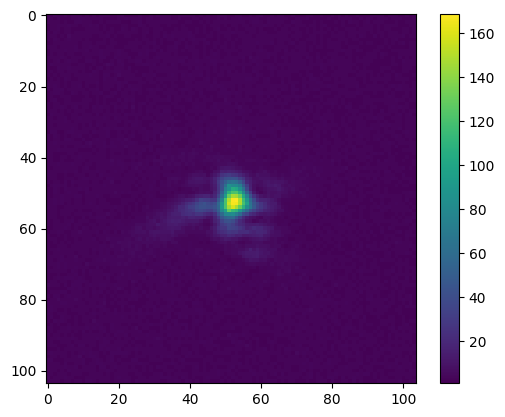

In [45]:
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
plt.colorbar()

print(frame.shape)

init.close_cam()
# 

#### Define cost function
Two cost functions are tested. One maximises the energy on a given circle on the frame and one maximized the correlation coefficient between the frame and a (gaussian) target spot. 

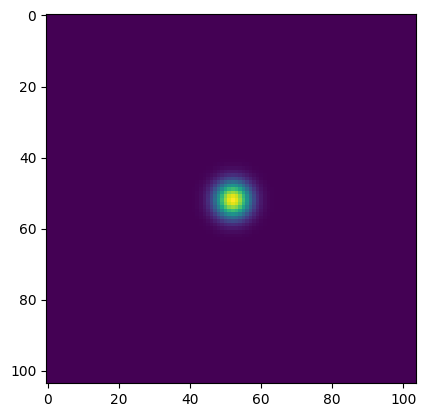

In [39]:
# define cost function and pass it to the object
cost_fun = lambda x: cost_functions.snr(x, 5, (-1, -2))
gauss = GaussPatternGenerator(N=104, w0=1e-3) 
amp, _ = gauss[0]
cost_fun = lambda x: cost_functions.corr_coef(x, amp)

plt.imshow(amp)

#### Optimize

In [42]:
# define how many polynomials to optimize
num = 15

# instantiate zernike class
zern = ZernikePolynomials(slm, 
                           camera,
                           num_of_zernike_coeffs=num, 
                           slm_calibration_pixel=112)

# pass cost function to object
zern.register_callback(cost_fun)

# run algorithm
mask, coeffs, cost, frames = zern.run((-1.5, 2, 0.2))

# load optimized mask to SLM
slm.sendArray(mask)

  0%|          | 0/15 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 0:   7%|▋         | 1/15 [00:12<02:54, 12.43s/it, Cost=0.777]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 1:  13%|█▎        | 2/15 [00:21<02:18, 10.69s/it, Cost=0.91] 

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 2:  20%|██        | 3/15 [00:30<01:57,  9.82s/it, Cost=0.933]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 3:  27%|██▋       | 4/15 [00:39<01:43,  9.44s/it, Cost=0.944]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 4:  33%|███▎      | 5/15 [00:48<01:32,  9.27s/it, Cost=0.951]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 5:  40%|████      | 6/15 [00:57<01:23,  9.33s/it, Cost=0.95] 

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 6:  47%|████▋     | 7/15 [01:07<01:14,  9.31s/it, Cost=0.953]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 7:  53%|█████▎    | 8/15 [01:16<01:05,  9.31s/it, Cost=0.952]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 8:  60%|██████    | 9/15 [01:25<00:55,  9.31s/it, Cost=0.954]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 9:  67%|██████▋   | 10/15 [01:35<00:46,  9.29s/it, Cost=0.953]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 10:  73%|███████▎  | 11/15 [01:44<00:37,  9.29s/it, Cost=0.953]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 11:  80%|████████  | 12/15 [01:53<00:27,  9.25s/it, Cost=0.95] 

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 12:  87%|████████▋ | 13/15 [02:02<00:18,  9.22s/it, Cost=0.95]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 13:  93%|█████████▎| 14/15 [02:14<00:10, 10.09s/it, Cost=0.953]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 14: 100%|██████████| 15/15 [02:27<00:00,  9.81s/it, Cost=0.953]

Data transmitted
Data transmitted


1

### Do some plotting and save

In [ ]:
with open('optimize_aberrations.pkl', 'wb') as fp:
    pickle.dump((mask, coeffs, cost, frames), fp)

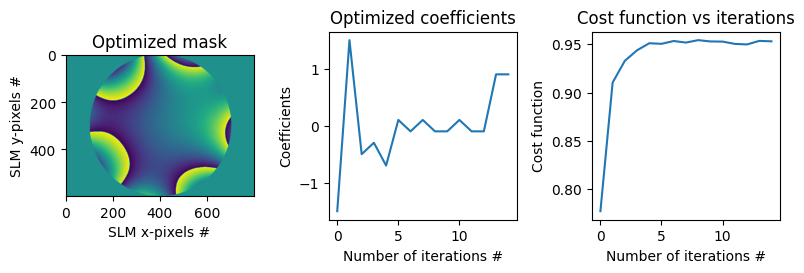

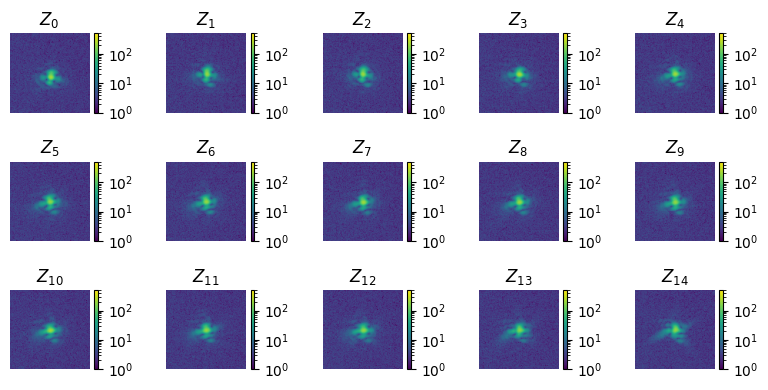

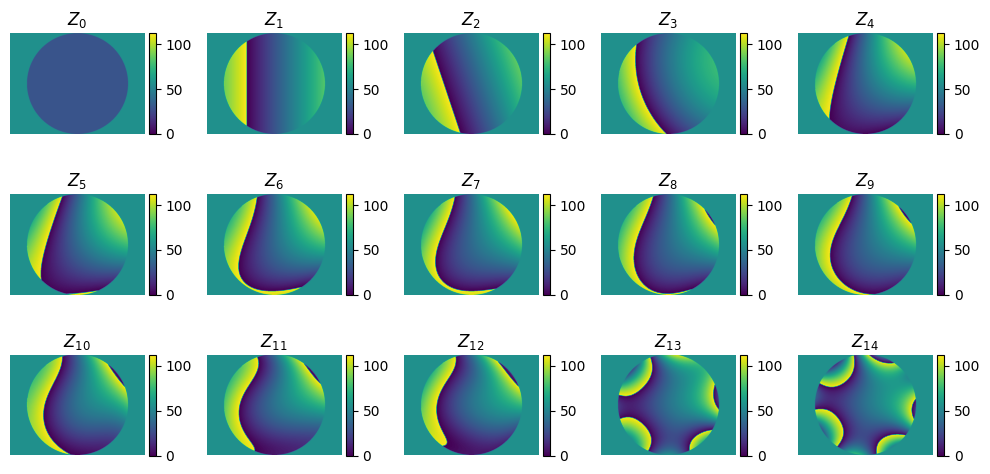

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
axs[0].imshow(mask)
axs[0].set_title("Optimized mask")
axs[0].set_xlabel("SLM x-pixels #")
axs[0].set_ylabel("SLM y-pixels #")


axs[1].plot(coeffs)
axs[1].set_title("Optimized coefficients")
axs[1].set_xlabel("Number of iterations #")
axs[1].set_ylabel("Coefficients")
axs[1].set_box_aspect(1)


axs[2].plot(cost)
axs[2].set_title("Cost function vs iterations")
axs[2].set_xlabel("Number of iterations #")
axs[2].set_ylabel("Cost function")
axs[2].set_box_aspect(1)

fig.tight_layout()
# plt.savefig("optimize_aberrations1.png", dpi=400, transparent=True)


fig, axs = plt.subplots(nrows=int(3), ncols=int(5), figsize=(8, 4))
count = 0
for matrix, ax in zip(frames[1].values(), axs.ravel()):
    im = ax.imshow(matrix, norm=LogNorm(vmin=1, vmax=500))
    # im = ax.imshow(matrix, vmin=1, vmax=500)
    ax.axis('off')
    ax.set_title(r"$Z_{%d}$" %count)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    count += 1
fig.tight_layout()

# plt.savefig("optimize_aberrations2.png", dpi=400, transparent=True)


fig, axs = plt.subplots(nrows=int(3), ncols=int(5), figsize=(10, 5))
count = 0
for matrix, ax in zip(frames[0].values(), axs.ravel()):
    im = ax.imshow(matrix, vmin=0, vmax=112)
    ax.axis('off')
    ax.set_title(r"$Z_{%d}$" %count)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    count += 1
fig.tight_layout()

# plt.savefig("optimize_aberrations3.png", dpi=400, transparent=True)

    

In [44]:
import pandas as pd
mask = pd.DataFrame(mask)
mask.to_csv('mask2.csv', header=False, index=False)

In [ ]:
df = pd.read_csv('mask.csv', header=None)
mask = df.to_numpy()
plt.imshow(mask)


#### efforts to do the same thing but with LG modes - in progress

In [ ]:
shape = (600, 800)
radius = 300
center = [600 // 2, 800 // 2]

gauss = GaussPatternGenerator(N=2*radius, num=16, w0=1e-2, LG=True)

In [ ]:



def get_disk_mask(radius, center = None):
    '''
    Generate a binary mask with value 1 inside a disk, 0 elsewhere
    :param shape: list of integer, shape of the returned array
    :radius: integer, radius of the disk
    :center: list of integers, position of the centerfrom aotools.functions import phaseFromZernikes

    :return: numpy array, the resulting binary mask
    '''
    shape = [2 * radius] * 2
    if not center:
        center = (shape[0] // 2, shape[1] // 2)
    X, Y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    mask = (Y - center[0]) ** 2 + (X - center[1]) ** 2 < radius ** 2
    
    return mask.astype('bool')

def phaseFromGauss(gCoeffs, radius):

    mask = np.zeros((radius, radius))
    for idx in range(len(gCoeffs)):
        amp, phase = gauss[idx]
        mask += phase * gCoeffs[idx]
        
    return mask

def phase2SLM(mask):
    mask2pi = mask% 2 * np.pi
    # scale phase between 0 and 2pi
    # arg2pi = (arg + 2 * np.pi) % (2 * np.pi)
    # normalize to SLM 2pi calibration value
    mask2SLM = mask2pi * 112 / (2 * np.pi) 
    
    return mask2SLM.astype('uint8')
    
def complex_mask_from_gauss_coeff(vec, shape, radius, center):
    '''
    Generate a complex phase mask from a vector containting the coefficient of the first Zernike polynoms.
    :param DMD_resolution: list of integers, contains the resolution of the DMD, e.g. [1920,1200]
    :param: integer, radius of the illumination disk on the DMD
    :center: list of integers, contains the position of the center of the illumination disk
    :center: list of float, the coefficient of the first Zernike polynoms
    '''
    
# Generate a complex phase mask from the coefficients
    zern_mask = phaseFromGauss(vec, 2 * radius)
    print(zern_mask.shape)
    
    # We want the amplitude to be 0 outside the disk, we fist generate a binary disk mask
    amp_mask = get_disk_mask(radius)
    print(amp_mask.shape)
    
    # put the Zernik mask at the right position and multiply by the disk mask
    mask = np.zeros(shape = shape, dtype='uint8')
    mask[center[0] - radius:center[0] + radius,
         center[1] - radius:center[1] + radius] = zern_mask * amp_mask
    
    return mask

# amp_mask = complex_mask_from_gauss_coeff([1, 2])
# plt.imshow(abs(amp_mask))

# mask = get_disk_mask(radius)
# plt.imshow(mask)

g = phaseFromGauss([1, 1, 1], 2 * radius)
plt.figure()
plt.imshow(g)

mask2 = complex_mask_from_gauss_coeff([1, 2, 1, 1, 1, 1, 1,1 , 1], shape, radius, center)
mask2 = phase2SLM(mask2)
# plt.figure()
plt.imshow(mask2)
plt.colorbar()

In [ ]:
from aotools.functions import phaseFromZernikes
import matplotlib.pyplot as plt
from slmOptim.patternSLM.patterns import GaussPatternGenerator

vec = [1, 1, 0, 0]
radius = 100

gauss = GaussPatternGenerator(N=2*radius, num=16, w0=1e-2, LG=True)

def phaseFromGauss(gCoeffs, radius):

    mask = np.zeros((radius, radius))
    for idx in range(len(gCoeffs)):
        amp, phase = gauss[idx]
        mask += phase * gCoeffs[idx]
        
    return mask

zern = phaseFromZernikes(vec, 2 * radius)

plt.figure()
plt.imshow(zern)
plt.colorbar()

g = phaseFromGauss(vec, 2 * radius)

plt.figure()
plt.imshow(g)
plt.colorbar()


In [ ]:
vec = [1, 1, 1, 1, 1, 1, 1]
g = phaseFromGauss(vec, 2 * radius)
plt.imshow(g )
plt.colorbar()

In [ ]:
im1 = gauss[0][0]
im2 = gauss[1][0]

In [ ]:
plt.imshow(im1)
plt.colorbar()

In [ ]:
had = pt.HadamardPatternGenerator(256, 112)

pattern = had[150]
patternSLM = pt.Pattern(800, 600)

mask = patternSLM._enlarge_pattern(pattern, 5)
mask = patternSLM.add_subpattern(mask)

slm.sendArray(mask)